In [1]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
import time

plt.rcParams['font.size'] = 7

imgShow함수: 스크립트에서 이미지 바로 출력

In [2]:
# 이미지를 스크립트에서 바로 확인(BGR 이미지)
def imgShow(image,title): # 이미지, 타이틀 입력
    rgbImg = cv2.cvtColor(image,cv2.COLOR_BGR2RGB) # BGR 에서 RGB로 변환
    plt.figure(figsize=(3,3))
    plt.title(title)
    plt.imshow(rgbImg)
    plt.show()
# 이미지를 스크립트에서 바로 확인(RGB 이미지)
def imgShow2(image,title): # 이미지, 타이틀 입력
    plt.figure(figsize=(3,3))
    plt.title(title)
    plt.imshow(image)
    plt.show()

In [4]:
# image load
imagePath = './image/mt_low.jpg'
image = cv2.imread(imagePath)
image = image[:-320,:,:]
image.shape

(640, 640, 3)

##### [NOTE] Translation 함수

이미지를 x, y만큼 이동시키는 함수.
- image: 이동시킬 이미지
- x: x축으로 이동할 거리(좌-/우+)
- y: y축으로 이동할 거리(상-/하+)
- keepSize: True는 원본 이미지 크기 유지/ False는 원본 이미지 유지(새로운 크기의 이미지 생성)
- fiiColor: 새로운 영역을 채울 색상(default=검정)

keepSize가 True인 경우, translation matrix를 사용하여 원본 이미지의 크기를 유지한 상태애서 이미지를 이동시키고 fillColor변수에 지정된 색상으로 비어있는 영역 채움.<br/>
keepSize가 False인 경우, left padding과 top padding을 계산하여 translation matrix 생성하여 이미지를 이동시킴.<br/>
이동된 이미지 return

In [5]:
# translation 함수
def translate(image, x, y, keepSize=True, fillColor=(0, 0, 0)):
    # 이미지 height, width 얻음
    height, width = image.shape[:2]
    
    if keepSize: # original image size 유지
        translationMatrix = np.float32([[1, 0, x], [0, 1, y]])
        transformedImage= cv2.warpAffine(image, translationMatrix, (width,height),
                                            borderValue=fillColor)
    else: # original image 유지
        leftPadding = max(0,-x)
        topPadding = max(0,-y)
        newWidth = width + abs(x)
        newHeight = height + abs(y)

        # translation matrix + 보정값
        translationMatrix = np.float32([[1 , 0 , x + leftPadding],
                                        [0 , 1 , y + topPadding]])
        # 이미지 변환
        transformedImage= cv2.warpAffine(image[topPadding : topPadding+newHeight, leftPadding : leftPadding+newWidth],
                                          translationMatrix,(newWidth,newHeight),
                                          borderValue=fillColor)
    return transformedImage

# translation x, y 설정 
translationX = +200
translationY = -100
# 흰색으로 빈 픽셀 채우고 원본 이미지 크기 유지 translation
transformedImagePreserveSize= translate(image=image, x=translationX, y=translationY, keepSize=True, fillColor=(255 ,255 ,255)) 
# 흰색으로 빈 픽셀 채우고 원본 이미지 유지 translation
transformedImagePreserveImage= translate(image=image,
                                              x=translationX, y=translationY,
                                              keepSize=False,
                                              fillColor=(255 ,255 ,255))

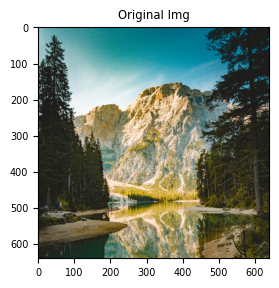

In [6]:
# 원본 이미지 출력
imgShow(image,"Original Img")

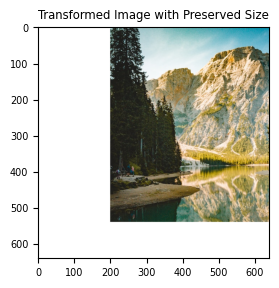

In [7]:
# 원본 이미지 크기 유지 translation 출력
imgShow(transformedImagePreserveSize,'Transformed Image with Preserved Size')

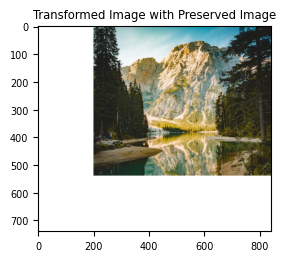

In [8]:
# 원본 이미지 유지 translation 출력
imgShow(transformedImagePreserveImage,'Transformed Image with Preserved Image')

##### [NOTE] Rotation 함수

이미지를 angle만큼 회전시키는 함수
- image: 회전시킬 이미지
- angle: 회전 각도(시계방향+/반시계방향-)
- keepSize: True는 원본 이미지 크기 유지. False는 원본 이미지 유지(새로운 크기 이미지 생성)
- fillColor: 새로운 영역을 채울 색상(default=검정)

keepSize가 True인 경우, rotation matrix 사용하여 원본 이미지 크기를 유지하면서 회전하고, fillColor 변수에 지정된 색상으로 비어있는 영역을 채움.<br/>
keepSize가 False인 경우, 회전 후 잘릴 부분이 없도록 새로운 이미지 크기(newWidth, newHeight) 계산. center와 ratationMatrix을 생성 후, transformedMatrix에 dx와 dy 값 할당하여 생성 후 이미지를 회전시킴.
회전된 이미지 return.


In [9]:
def rotate(image, angle, keepSize=True, fillColor=(0, 0, 0)):
    # 이미지 height, width 얻음
    height, width = image.shape[:2]
    # 이미지 중심점 계산
    center = (width // 2, height // 2)
    # 각도 라이안 변환
    radian = np.radians(angle)
    # sin, cos 값 계산
    sin = np.sin(radian)
    cos = np.cos(radian)

    if keepSize: # original image size 유지
        # Rotation Matrix 생성
        ratationMatrix= np.float32([[cos,-sin],[sin,+cos]])
        # 이동값(dx, dy) 계산
        dx=center[0]-center[0]*cos+center[1]*sin 
        dy=center[1]-center[0]*sin-center[1]*cos 
        # Transform Matrix 생성 (Rotaion Matrix + 이동값)
        transformMatrix=np.zeros((2,3)) 
        transformMatrix[:2,:2] +=ratationMatrix 
        transformMatrix[:,2]=np.array([dx, dy])

        # 이미지 변환
        transformedImage=cv2.warpAffine(image,transformMatrix ,(width,height),borderValue=fillColor)
    
    else: # original image 유지
        # 회전 후, 새로운 image size 계산
        newWidth = int(np.abs(sin * height) + np.abs(cos * width))
        newHeight = int(np.abs(cos * height) + np.abs(sin * width))
        # 새로운 중심 좌표 계산, 이동값(dx, dy) 적용
        newCenter = (newWidth // 2, newHeight // 2)
        # Rotation Matrix 생성
        rotationMatrix= np.float32([[cos,-sin],[sin,cos]])
        # 이동값(dx, dy) 계산
        dx=newCenter[0]-center[0]*cos+center[1]*sin 
        dy=newCenter[1]-center[0]*sin-center[1]*cos 
        # Transform Matrix 생성 (Rotaion Matrix + 이동값)
        transformMatrix=np.zeros((2,3)) 
        transformMatrix[:2,:2] += rotationMatrix
        transformMatrix[:,2]=np.array([dx, dy])
        # 이미지 변환
        transformedImage=cv2.warpAffine(image,transformMatrix ,(newWidth,newHeight),borderValue=fillColor)

    return transformedImage

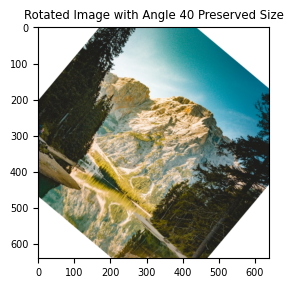

In [11]:
# 흰색으로 빈 픽셀 채우고 원본 이미지 크기 유지하면서 40 rotation
rotaion40ImagePreserveSize= rotate(image=image, angle=40, keepSize=True, fillColor=(255 ,255 ,255))
imgShow(rotaion40ImagePreserveSize,'Rotated Image with Angle 40 Preserved Size')

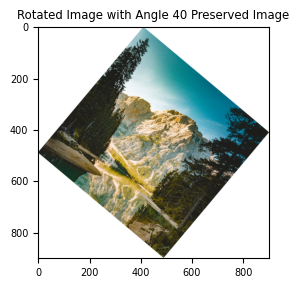

In [10]:
# 흰색으로 빈 픽셀 채우고 원본 이미지 유지하면서 40 rotation
rotaion40ImagePreserveImage= rotate(image=image, angle=40, keepSize=False, fillColor=(255 ,255 ,255))
imgShow(rotaion40ImagePreserveImage,'Rotated Image with Angle 40 Preserved Image')

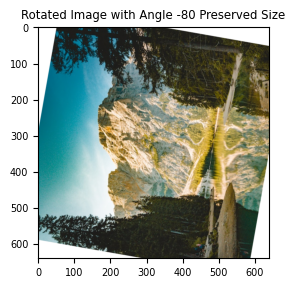

In [12]:
# 흰색으로 빈 픽셀 채우고 원본 이미지 크기 유지하면서 -80 rotation
rotaion_80ImagePreserveSize= rotate(image=image, angle=-80, keepSize=True, fillColor=(255 ,255 ,255))
imgShow(rotaion_80ImagePreserveSize,'Rotated Image with Angle -80 Preserved Size')

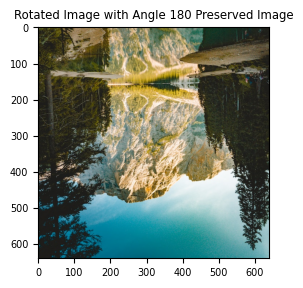

In [13]:
# 흰색으로 빈 픽셀 채우고 원본 이미지 유지하면서 180 rotation
rotaion180ImagePreserveImage= rotate(image=image, angle=180, keepSize=False, fillColor=(255 ,255 ,255))
imgShow(rotaion180ImagePreserveImage,'Rotated Image with Angle 180 Preserved Image')

##### [NOTE] Affine Transform 함수
- image: Affine 변환 적용할 이미지
- srcImage: 변환 전의 이미지 (x,y)좌표 3개   ex)[[0,0], [640, 0], [640, 640]]
- dstPoint: 변환 후의 목표 이미지 (x,y)좌표 3개   ex)[[50,50], [500, 200], [700, 700]]
- expand: True/False, True일 경우 변환된 이미지 전체를 포함하는 새로운 이미지 크기 생성 <br/>

cv2.getAffineTransform은 점 세개의 정보 통해, 변환 정보를 어파인 행렬로 표시 가능. 세개의 변환 정보로 다른 4번째 점의 위치 자동 계산.

In [14]:
def AffineTransformation(image, srcPoint, dstPoint, expand=True):
    # 이미지 height, width 얻음
    height, width = image.shape[:2]
    # 변환 전과 후의 좌표를 NumPy 배열로 변환
    srcPoint = np.float32(srcPoint)
    dstPoint = np.float32(dstPoint)
    # Affine 변환 행렬 생성
    transformMatrix = cv2.getAffineTransform(srcPoint, dstPoint)

    if expand:
        # 확장된 출력 크기 계산
        maxWidth = max(np.max(dstPoint[:, 0]), width) - min(np.min(dstPoint[:, 0]), 0)
        maxHeight = max(np.max(dstPoint[:, 1]), height) - min(np.min(dstPoint[:, 1]), 0)
        # 확장된 이미지에서 원본 이미지 위치 조정 (변경점)
        transformMatrix[0][2] -= min(np.min(dstPoint[:, 0]), 0)
        transformMatrix[1][2] -= min(np.min(dstPoint[:, 1]), 0)
        # 확장된 크기로 Affine 변환 적용
        transformedImage = cv2.warpAffine(image,
                                           transformMatrix,
                                           (int(maxWidth), int(maxHeight)))
        return transformedImage
    else:
        # 원본 크기로 Affine 변환 적용 
        transformedImage= cv2.warpAffine(image ,transformMatrix ,(width,height))

        return transformedImage

# 원본 좌표와 목표 좌표 정의
affineSrcPoints = [[0,0], [640, 0], [640, 640]]
affineDstPoints = [[-50,50], [500, 200], [800, 800]]

# Affine 변환 수행
affineTransImageOriginalView = AffineTransformation(image, affineSrcPoints, affineDstPoints, expand=False)
affineTransImageExpandedView = AffineTransformation(image, affineSrcPoints, affineDstPoints, expand=True)

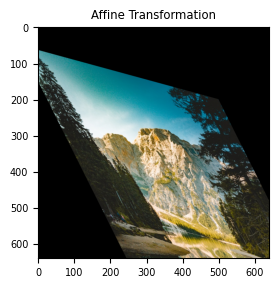

In [15]:
# Affine 변환 수행(원본 이미지 크기 유지)
affineTransImageOriginalView = AffineTransformation(image, affineSrcPoints, affineDstPoints, expand=False)
imgShow(affineTransImageOriginalView, "Affine Transformation")

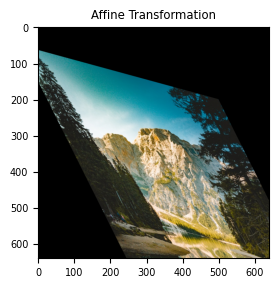

In [16]:
# Affine 변환 수행(원본 이미지 크기 유지)
affineTransImageOriginalView = AffineTransformation(image, affineSrcPoints, affineDstPoints, expand=False)
imgShow(affineTransImageOriginalView, "Affine Transformation")

##### [NOTE] Perspective Transform 함수
- image: Perspective 변환 적용할 이미지
- srcImage: 변환 전의 이미지 (x,y)좌표 4개   ex)[[0 ,0], [640 ,0], [640 ,640], [0 ,640]]
- dstPoint: 변환 후의 목표 이미지 (x,y)좌표 3개   ex)[[70 ,100], [620 ,50], [800 ,600], [100 ,700]]
- expand: True/False, True일 경우 변환된 이미지 전체를 포함하는 새로운 이미지 크기 생성 <br/>

cv2.getPerspectiveTransform은 점 4개의 정보 통해, 변환 정보를 Perspective 행렬로 표시. 어파인 변환에 비해 자유도가 높은 변환.

In [17]:
def PerspectiveTransformation(image, srcPoint, dstPoint, expand=True):
    # 이미지 height, width 얻음
    height, width = image.shape[:2]
    # 변환 전과 후의 좌표를 NumPy 배열로 변환
    srcPoint = np.float32(srcPoint)
    dstPoint = np.float32(dstPoint)
    # 변환 행렬 생성
    transformMatrix = cv2.getPerspectiveTransform(srcPoint, dstPoint)
    
    if expand:
        # 확장된 출력 크기 계산
        maxWidth = max(np.max(dstPoint[:, 0]), width) - min(np.min(dstPoint[:, 0]), 0)
        maxHeight = max(np.max(dstPoint[:, 1]), height) - min(np.min(dstPoint[:, 1]), 0)
        # 확장된 변환 행렬 생성
        expandedTransformMatrix = np.array([[1, 0, -min(np.min(dstPoint[:, 0]), 0)],
                                            [0, 1, -min(np.min(dstPoint[:, 1]), 0)],
                                            [0, 0 ,1]])
        transformMatrix = expandedTransformMatrix @ transformMatrix
        # Perspective 확장된 변환 적용
        transformedImage = cv2.warpPerspective(image, transformMatrix,
                                               (int(maxWidth), int(maxHeight)))
        return transformedImage
    
    else:
         # Perspective 변환 적용 (기존 방식 유지)
         transformedImage = cv2.warpPerspective(image, transformMatrix,
                                                (width ,height))
         return transformedImage

# 원본 좌표 정의 (4개의 점)
perspTransSrcPoints = [[0 ,0], [640 ,0], [640 ,640], [0 ,640]]
# 목적 좌표 정의 (4개의 점)
perspTransDstPoints = [[-70 ,100], [620 ,50], [800 ,600], [100 ,900]]

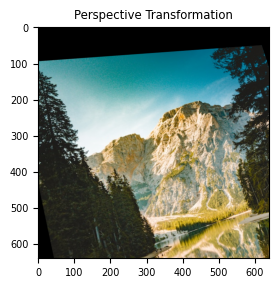

In [18]:
# Perspective 변환 수행(원본 이미지 사이즈 유지)
perspTransImageOriginalView= PerspectiveTransformation(image,
                                                        perspTransSrcPoints,
                                                        perspTransDstPoints,
                                                        expand=False)
imgShow(perspTransImageOriginalView, "Perspective Transformation")

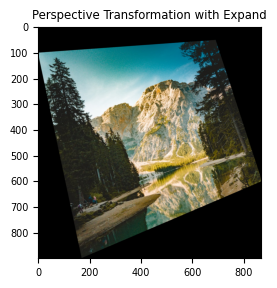

In [19]:
 # Perspective 변환 수행(원본 이미지 영역 유지)
perspTransImageExpandedView= PerspectiveTransformation(image,
                                                        perspTransSrcPoints,
                                                        perspTransDstPoints,
                                                        expand=True)
imgShow(perspTransImageExpandedView, "Perspective Transformation with Expand")

Affine & Perspective transformation 좌표 변환 비교

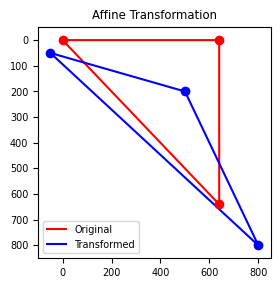

In [20]:
def plotPoints(srcPoints, dstPoints, image):
    # Point를 x와 y로 분리
    x1 = [point[0] for point in srcPoints]
    y1 = [point[1] for point in srcPoints]
    x2 = [point[0] for point in dstPoints]
    y2 = [point[1] for point in dstPoints]

    # 첫 번째 점과 마지막 점 연결 그래프
    if len(srcPoints) == 3:
        plt.figure(figsize=(3,3))
        plt.title("Affine Transformation")
        plt.plot(x1 + [x1[0]], y1 + [y1[0]], 'r-', label='Original')
        plt.plot(x2 + [x2[0]], y2 + [y2[0]], 'b-', label='Transformed')
    elif len(srcPoints) == 4:
        plt.figure(figsize=(3,3))
        plt.title("Perspective Transformation")
        plt.plot(x1 + [x1[0]], y1 + [y1[0]], 'r-', marker='o', markersize=8, linewidth=2, label='Original')
        plt.plot(x2 + [x2[0]], y2 + [y2[0]], 'b-', marker='o', markersize=8, linewidth=2, label='Transformed')

    # 각 점을 원으로 표시
    plt.plot(x1, y1, 'ro')
    plt.plot(x2, y2, 'bo')
    # 축 범위 설정
    plt.xlim(min(min(x1), min(x2)) - 50, max(max(x1), max(x2)) + 50)
    plt.ylim(min(min(y1), min(y2)) - 50, max(max(y1), max(y2)) + 50)
    # 범례 추가
    plt.legend(loc='lower left')
    # y축 inverse
    plt.gca().invert_yaxis()
    plt.show()

# 원본 이미지 좌표 정의
affineSrc3Points = affineSrcPoints
perspSrc4Points = perspTransSrcPoints
# 변환 이미지 좌표 정의
perspDst3Points = affineDstPoints
perspDst4Points = perspTransDstPoints
# Affien 변환 좌표 플롯 생성 (3개 Points)
plotPoints(affineSrc3Points,perspDst3Points, affineTransImageExpandedView)

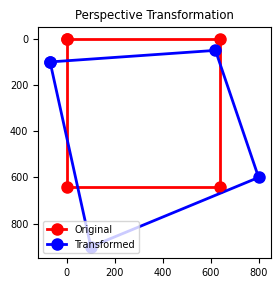

In [21]:
# Perspective 변환좌표 플롯 생성 (4개 Points)
plotPoints(perspSrc4Points,perspDst4Points, perspTransImageExpandedView)